In [67]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
words = open('AI4-names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} 
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()} 

In [69]:
#build dataset
block_size = 3 #context length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
    
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# training split, dev/validation split, test split
# 80%, 10%, 10%
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [70]:
g = torch.Generator().manual_seed(2147483647) #deterministic reproducibility
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,300), generator=g) #increase size of NN
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [71]:
sum(p.nelement() for p in parameters) #number of parameters in total

10281

In [72]:
lossi = []
stepi = []

In [73]:
for i in range(30000):
    
    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,)) #use training set
    
    #forward pass
    emb = C[Xtr[ix]] #use training set
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Ytr[ix]) #use training set
    #print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.01 #0.1 first run, 0.01 second run
    for p in parameters:
        p.data += -lr * p.grad
        
    #track stats
    stepi.append(i)
    lossi.append(loss.item())
        
print(loss.item())

2.375009298324585


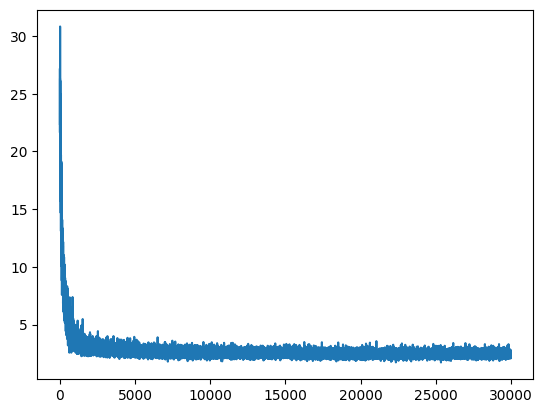

In [74]:
plt.plot(stepi, lossi)

In [75]:
emb = C[Xtr] #use training set to check
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr) #use training set to check
loss 

tensor(2.4432, grad_fn=<NllLossBackward0>)

In [76]:
emb = C[Xdev] #use dev set to evaluate
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev) #use dev set to evaluate
loss 

tensor(2.4396, grad_fn=<NllLossBackward0>)

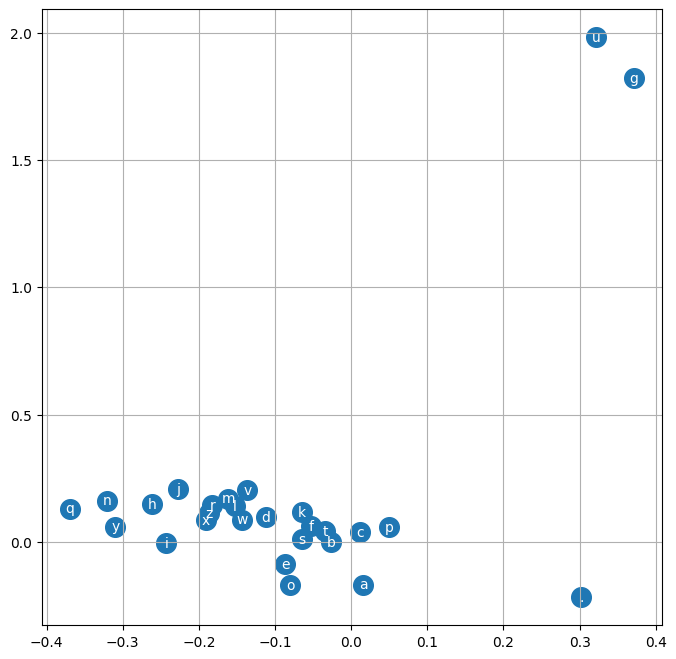

In [77]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')
#mapping of characters in 2 dimensional NN that we had built so far
#see vowels are quite closely embedded

In [78]:
#increase the embedding (C) from 2 to 10 dimensions
g = torch.Generator().manual_seed(2147483647) #deterministic reproducibility
C = torch.randn((27,10), generator=g) #10 d here
W1 = torch.randn((30,200), generator=g) #3x10=30 and slightly less neurons
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [79]:
sum(p.nelement() for p in parameters) #number of parameters in total

11897

In [80]:
lossi = []
stepi = []

In [81]:
for i in range(200000):
    
    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,)) #use training set
    
    #forward pass
    emb = C[Xtr[ix]] #use training set
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) #up to 30 here too
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Ytr[ix]) #use training set
    #print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    #track stats
    stepi.append(i)
    lossi.append(loss.log10().item())
        
print(loss.item())

2.1778924465179443


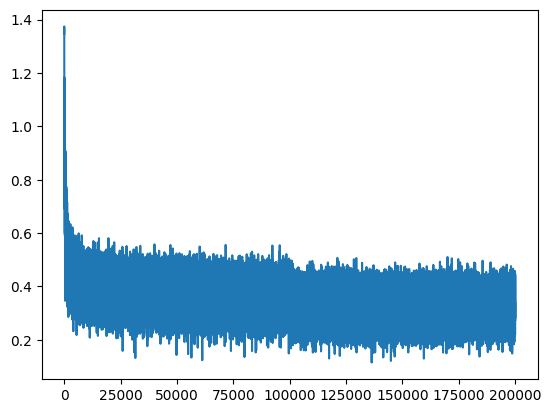

In [82]:
plt.plot(stepi, lossi)

In [83]:
emb = C[Xtr] #use training set to check
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) #30 here too
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr) #use training set to check
loss 

tensor(2.1373, grad_fn=<NllLossBackward0>)

In [84]:
emb = C[Xdev] #use dev set to evaluate
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) #30 here too
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev) #use dev set to evaluate
loss 

tensor(2.1769, grad_fn=<NllLossBackward0>)

In [87]:
#finally lets sample from the new NN model
g = torch.Generator().manual_seed(2147483647 + 10)

for i in range(20): #20 samples
    
    out = []
    context = [0] * block_size #start with dot
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))
    
#much better word like generations

carlah.
amelle.
khi.
milia.
aty.
skaansie.
mahnen.
delynn.
ivanni.
nellara.
chaiir.
kaleigh.
ham.
pori.
quinthonor.
malianni.
wazeroniearyni.
fine.
pilsan.
edde.
